# Enriching Vessel Location Data
## Loading the Data :

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Point
from scipy.spatial import cKDTree
from pathlib import Path
import requests
import zipfile
import io

from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from scipy.spatial import cKDTree
import xgboost as xgb

import geodatasets
import psycopg2

In [4]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname="ais_project",
    user="postgres",
    password="120705imad",
    host="localhost"
)

# Query the raw AIS data
query = "SELECT * FROM raw_ais_data"
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Check the first few rows
df.head()

/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_5605/1358359146.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,id,vessel_id,latitude,longitude,timestamp,raw_json
0,1,219598000,55.770832,20.851690,2022-07-30 23:28:58.646,"{'mmsi': 219598000, 'type': 'Feature', 'geomet..."
1,2,376128000,59.180200,19.612433,2021-12-08 07:18:31.289,"{'mmsi': 376128000, 'type': 'Feature', 'geomet..."
2,3,273274000,59.886713,30.190985,2018-10-18 01:20:47.556,"{'mmsi': 273274000, 'type': 'Feature', 'geomet..."
3,4,231319000,56.052607,17.597902,2019-12-05 03:55:51.243,"{'mmsi': 231319000, 'type': 'Feature', 'geomet..."
4,5,538007963,58.876633,21.255277,2023-07-03 00:43:11.378,"{'mmsi': 538007963, 'type': 'Feature', 'geomet..."


previewing data :

In [6]:
df['raw_json'].iloc[0]

{'mmsi': 219598000,
 'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [20.85169, 55.770832]},
 'properties': {'cog': 346.5,
  'rot': 4,
  'sog': 0.1,
  'mmsi': 219598000,
  'raim': True,
  'posAcc': True,
  'heading': 79,
  'navStat': 1,
  'timestamp': 59,
  'timestampExternal': 1659212938646}}

Based on the preview and the official data source documentationn here's a breakdown of the structure:

**Feature Object** (Individual Vessel)
- `type`: Always `"Feature"` (geospatial object with geometry + properties).
- `mmsi`: **Maritime Mobile Service Identity** (9-digit unique vessel identifier).
- `geometry`: 
  - `type`: Always `"Point"` (coordinates represent a single position).
  - `coordinates`: **[Longitude, Latitude]** in WGS84 decimal degrees (EPSG:4326).

**Properties Object** (Vessel Metadata)
- `sog`: **Speed Over Ground** (0.1 = 0.1 knots in this example).
- `cog`: **Course Over Ground** (346.5° true north, 0-359.9°).
- `navStat`: **Navigational Status** (1 = "Underway using engine" per [AIS standards](https://www.navcen.uscg.gov/ais-status-codes)).
- `rot`: **Rate of Turn** (±127 = degrees/minute, 4 = slow turn in this example).
- `posAcc`: **Position Accuracy** (`true` = high-accuracy GPS/DGPS, `false` = >10m error).
- `raim`: **Receiver Autonomous Integrity Monitoring** (`true`/`false` for GPS reliability checks).
- `heading`: **True Heading** (79° in this example, 0-359°).
- `timestamp`: **Internal timestamp** (59 = seconds from last minute/UTC second).
- `timestampExternal`: **External timestamp** (1659212938646 = Unix epoch milliseconds = Thu Jul 30 2022 12:28:58 UTC).



##### Key Notes:
- Coordinates follow GeoJSON `[lon, lat]` order (not lat/lon).
- Timestamps may need conversion for human readability (use `datetime` libraries).
- MMSI prefixes indicate vessel origin (219 = Denmark in this example).

## 2- Data Preprocessing

In [8]:
# Extract properties from raw_json
df['sog'] = df['raw_json'].apply(lambda x: x['properties']['sog'])
df['cog'] = df['raw_json'].apply(lambda x: x['properties']['cog'])
df['navStat'] = df['raw_json'].apply(lambda x: x['properties'].get('navStat'))
df['rot'] = df['raw_json'].apply(lambda x: x['properties'].get('rot'))
df['posAcc'] = df['raw_json'].apply(lambda x: x['properties'].get('posAcc'))
df['raim'] = df['raw_json'].apply(lambda x: x['properties'].get('raim'))
df['heading'] = df['raw_json'].apply(lambda x: x['properties'].get('heading'))
df['timestampExternal'] = df['raw_json'].apply(lambda x: x['properties'].get('timestampExternal'))

# Drop unnecessary columns
df = df.drop(columns=['id', 'raw_json'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract vessel origin from MMSI
mid_country = pd.read_csv('mid_to_country.csv').set_index('MID') 
df['mid'] = df['vessel_id'].astype(str).str[:3].astype(int)
df['country'] = df['mid'].map(mid_country['Country'])

# Convert boolean features to numerical
df['posAcc'] = np.where(df['posAcc'], 1, 0)
df['raim'] = np.where(df['raim'], 1, 0)

# Sort by timestamp
df = df.sort_values('timestamp')

## 3- Feature Engineering

In [10]:
# Calculate time differences in seconds
df['time_diff'] = df['timestamp'].diff().dt.total_seconds().fillna(0)

# Corrected positional delta calculations
df['delta_lat'] = (df['sog'] * 0.51444 * np.cos(np.radians(df['cog'])) * df['time_diff']) / 111_111
df['delta_lon'] = (df['sog'] * 0.51444 * np.sin(np.radians(df['cog'])) * df['time_diff']) / (111_111 * np.cos(np.radians(df['latitude'])))

# Set deltas to 0 when time_diff <= 0
df.loc[df['time_diff'] <= 0, ['delta_lat', 'delta_lon']] = 0

# Fill NaN values
df['delta_lat'] = df['delta_lat'].fillna(0)
df['delta_lon'] = df['delta_lon'].fillna(0)

## 4- Geospatial features

In [12]:
import requests
import zipfile
from io import BytesIO
from pathlib import Path
from shapely.geometry import Point

# Download Natural Earth dataset
url = "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
extract_path = Path("natural_earth_data")
if not (extract_path / "ne_10m_admin_0_countries.shp").exists():
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as z:
        z.extractall(extract_path)

# Load land geometry (Baltic Sea region)
world = gpd.read_file(extract_path / "ne_10m_admin_0_countries.shp")
land = world[world['NAME'].isin(['Sweden', 'Finland', 'Denmark', 'Germany', 'Poland', 'Lithuania', 'Latvia', 'Estonia', 'Russia'])].geometry

# Create geometry and check if points are over water
points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
df['is_water'] = ~points.geometry.apply(lambda pt: land.contains(pt).any())

## 5- Preparing Features & Targets

In [31]:
from sklearn.model_selection import train_test_split

# Feature set
features = ['latitude', 'longitude', 'sog', 'cog', 'navStat', 'rot', 'posAcc', 'raim', 'heading', 'time_diff', 'delta_lat', 'delta_lon', 'is_water']
X = df[features]
y = df[['latitude', 'longitude']].shift(-1)  # Next position

# Remove rows with NaN targets
mask = ~y.isna().any(axis=1)
X = X.loc[mask]
y = y.loc[mask]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

## 6 - Building & Testing Models

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['navStat']),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), ['latitude', 'longitude', 'sog', 'cog', 'rot', 'heading', 'time_diff', 'delta_lat', 'delta_lon', 'is_water']),
        ('binary', 'passthrough', ['posAcc', 'raim'])
    ])

# Define model pipelines
models = {
    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression(n_jobs=-1))
    ]),
    "Polynomial Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=2)),
        ('regressor', LinearRegression(n_jobs=-1))
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_jobs=-1))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(n_jobs=-1))
    ])
}

# Train models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

Linear Regression trained.
Polynomial Regression trained.
Random Forest trained.
XGBoost trained.


## 7 - Predictions & Post-Processing

In [35]:
from scipy.spatial import cKDTree

# Function to check if a point is over water
def is_over_water(lon, lat, land_geometry):
    point = Point(lon, lat)
    return not any(land_geometry.contains(point))

# Function to snap predictions to water
def snap_to_water(pred, actual, land_geometry, max_attempts=5, buffer_distance=0.1):
    pred_adjusted = pred.copy()
    water_points = actual[~np.array([not is_over_water(lon, lat, land_geometry) for lon, lat in actual])]
    tree = cKDTree(water_points)
    land_mask = np.array([not is_over_water(lon, lat, land_geometry) for lon, lat in pred_adjusted])
    
    if any(land_mask):
        distances, indices = tree.query(pred_adjusted[land_mask], k=1)
        pred_adjusted[land_mask] = water_points[indices]
    
    return pred_adjusted

# Make predictions and snap
predictions = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    predictions[name] = snap_to_water(y_pred, y_test.values, land)

## 8 - Evaluation 

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluation function
def evaluate_predictions(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    lat_mse = mean_squared_error(y_true['latitude'], y_pred[:, 0])
    lon_mse = mean_squared_error(y_true['longitude'], y_pred[:, 1])
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return [name, mse, lat_mse, lon_mse, mae, r2]

# Evaluate all models
results = []
for name, y_pred in predictions.items():
    results.append(evaluate_predictions(y_test, y_pred, name))

# Display results
df_results = pd.DataFrame(results, columns=["Model", "Overall MSE", "Lat MSE", "Lon MSE", "MAE", "R^2"])
print(df_results.round(4))

                   Model  Overall MSE  Lat MSE  Lon MSE     MAE     R^2
0      Linear Regression       1.4630   0.4469   2.4791  0.4539  0.7449
1  Polynomial Regression       1.4488   0.4310   2.4666  0.4472  0.7497
2          Random Forest       1.8168   0.5227   3.1109  0.5486  0.6898
3                XGBoost       1.4958   0.4444   2.5473  0.4505  0.7417


## 9 - Visualisation 

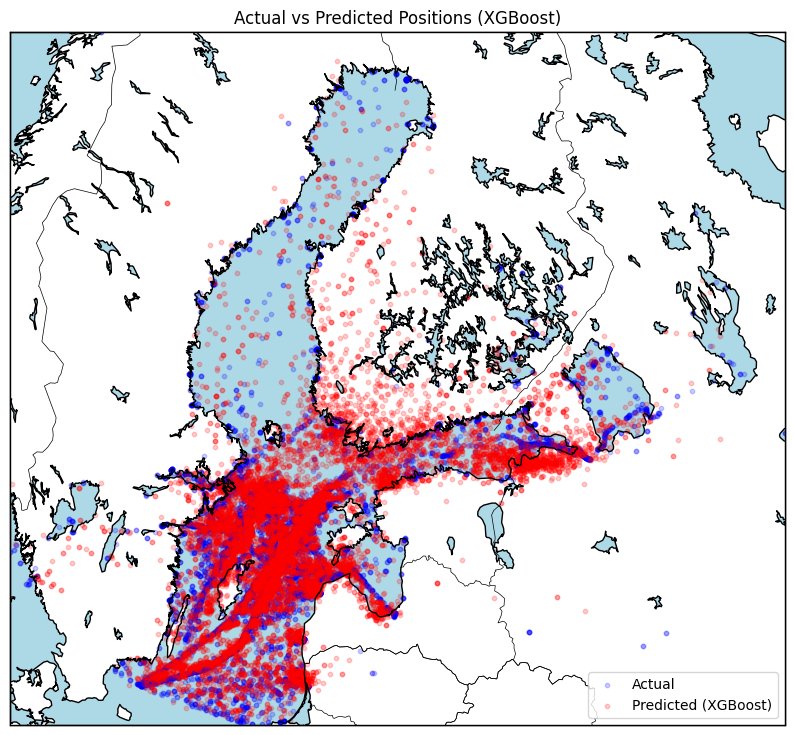

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(figsize=(12, 9))
m = Basemap(ax=ax, projection='merc', 
            llcrnrlat=y_test['latitude'].min(), llcrnrlon=y_test['longitude'].min(),
            urcrnrlat=y_test['latitude'].max(), urcrnrlon=y_test['longitude'].max(), 
            resolution='i')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='white', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Plot actual and predicted (e.g., XGBoost)
x_act, y_act = m(y_test['longitude'].values, y_test['latitude'].values)
x_pred, y_pred = m(predictions["XGBoost"][:, 1], predictions["XGBoost"][:, 0])
ax.scatter(x_act, y_act, alpha=0.2, s=10, color='blue', label='Actual')
ax.scatter(x_pred, y_pred, alpha=0.2, s=10, color='red', label='Predicted (XGBoost)')
ax.legend()
plt.title("Actual vs Predicted Positions (XGBoost)")
plt.show()

## 10 - Tuning Hyperparameters

[I 2025-03-10 18:56:23,301] A new study created in memory with name: no-name-e240e6ed-f449-4c4e-bf55-034a17e1885a
[I 2025-03-10 18:56:30,632] Trial 0 finished with value: 1.587729317667184 and parameters: {'n_estimators': 403, 'max_depth': 9, 'learning_rate': 0.03749283149466337, 'subsample': 0.5090998065053078, 'colsample_bytree': 0.6592197019356771, 'gamma': 0.10603731635650404, 'reg_alpha': 0.009776572831123542, 'reg_lambda': 0.058401679839618414}. Best is trial 0 with value: 1.587729317667184.
[I 2025-03-10 18:56:33,982] Trial 1 finished with value: 1.7385731717199084 and parameters: {'n_estimators': 171, 'max_depth': 10, 'learning_rate': 0.2813719779701284, 'subsample': 0.751557902153396, 'colsample_bytree': 0.9441610566327703, 'gamma': 0.980641758271928, 'reg_alpha': 0.088865052863357, 'reg_lambda': 0.1624712554980211}. Best is trial 0 with value: 1.587729317667184.
[I 2025-03-10 18:56:37,621] Trial 2 finished with value: 1.449892243153011 and parameters: {'n_estimators': 436, 'm

{'n_estimators': 432, 'max_depth': 3, 'learning_rate': 0.03821265131885728, 'subsample': 0.9510624507419833, 'colsample_bytree': 0.9068339501068202, 'gamma': 0.38683110367329177, 'reg_alpha': 0.34480120951271076, 'reg_lambda': 0.8074297227631062, 'n_jobs': -1}
                   Model  Overall MSE  Lat MSE  Lon MSE     MAE     R^2
0      Linear Regression       1.4630   0.4469   2.4791  0.4539  0.7449
1  Polynomial Regression       1.4488   0.4310   2.4666  0.4472  0.7497
2          Random Forest       1.8168   0.5227   3.1109  0.5486  0.6898
3                XGBoost       1.4958   0.4444   2.5473  0.4505  0.7417
4    XGBoost (Optimized)       1.4153   0.4207   2.4098  0.4381  0.7556


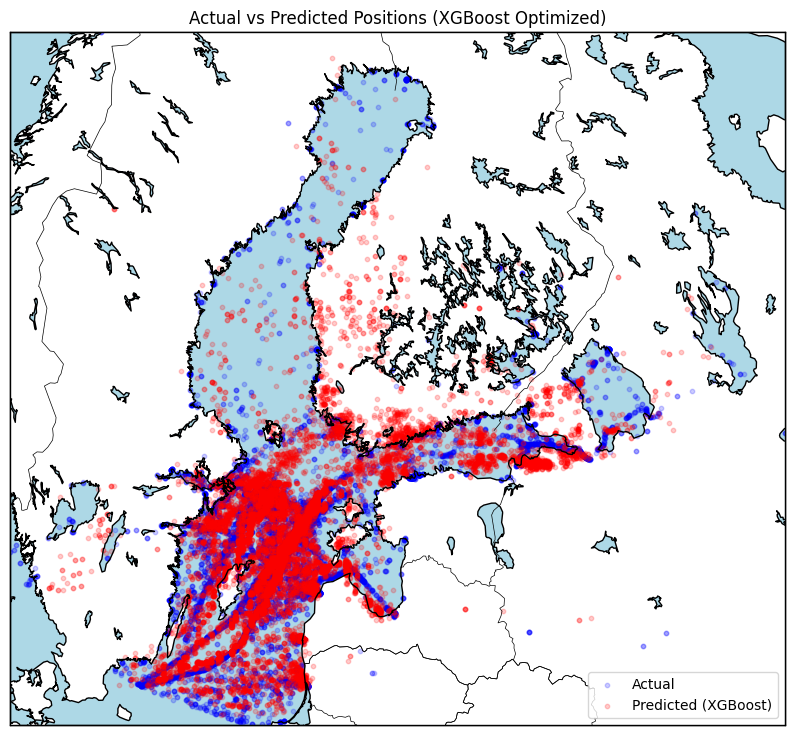

In [41]:
import optuna

# Create a study and optimize the objective function with early stopping
def objective(trial):
    # Define hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'n_jobs': -1
    }
    
    model = XGBRegressor(**params)
    model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_test, y_test)], 
        verbose=0
    )
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get best hyperparameters
best_params = study.best_params
best_params['n_jobs'] = -1
print(best_params)

# Train XGBoost with best hyperparameters
xgb_model = XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

# Make predictions and snap
y_pred = xgb_model.predict(X_test)
y_pred = snap_to_water(y_pred, y_test.values, land)

# Evaluate
results = evaluate_predictions(y_test, y_pred, "XGBoost (Optimized)")
new_row = pd.DataFrame([results], columns=df_results.columns)
df_results = pd.concat([df_results, new_row], ignore_index=True)
print(df_results.round(4))

# Plot actual and predicted (e.g., XGBoost)
fig, ax = plt.subplots(figsize=(12, 9))
m = Basemap(ax=ax, projection='merc', 
            llcrnrlat=y_test['latitude'].min(), llcrnrlon=y_test['longitude'].min(),
            urcrnrlat=y_test['latitude'].max(), urcrnrlon=y_test['longitude'].max(), 
            resolution='i')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='white', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')   

x_act, y_act = m(y_test['longitude'].values, y_test['latitude'].values)
x_pred, y_pred = m(y_pred[:, 1], y_pred[:, 0])
ax.scatter(x_act, y_act, alpha=0.2, s=10, color='blue', label='Actual')
ax.scatter(x_pred, y_pred, alpha=0.2, s=10, color='red', label='Predicted (XGBoost)')
ax.legend()
plt.title("Actual vs Predicted Positions (XGBoost Optimized)")
plt.show()

In [42]:
# Save the model
import joblib
joblib.dump(xgb_model, 'vessel_prediction_model.pkl')

['vessel_prediction_model.pkl']